# **Final Project Task 3 - Census Modeling Regression**

Requirements
- Create a regression model on the Census dataset, with 'hours-per-week' target

- You can use models (estmators) from sklearn, but feel free to use any library for traditional ML. 
    - Note: in sklearn, the LinearRegression estimator is based on OLS, a statistical method. Please use the SGDRegressor estimator, since this is based on gradient descent. 
    - You can use LinearRegression estimator, but only as comparison with the SGDRegressor - Optional.

- Model Selection and Setup **2p**:
    - Implement multiple models, to solve a regression problem using traditional ML: 
        - Linear Regression
        - Decision Tree Regression
        - Random Forest Regression - Optional
        - Ridge Regression - Optional
        - Lasso Regression - Optional
    - Choose a loss (or experiment with different losses) for the model and justify the choice. *1p*
        - MSE, MAE, RMSE, Huber Loss or others
    - Justify model choices based on dataset characteristics and task requirements; specify model pros and cons. *1p*


- Data Preparation
    - Use the preprocessed datasets from Task 1.
    - From the train set, create an extra validation set, if necesarry. So in total there will be: train, validation and test datasets.
    - Be sure all models have their data preprocessed as needed. Some models require different, or no encoding for some features.


- Model Training and Experimentation **10p**
    - Establish a Baseline Model *2p*
        - For each model type, train a simple model with default settings as a baseline.
        - Evaluate its performance to establish a benchmark for comparison.
    - Make plots with train, validation loss and metric on epochs (or on steps), if applicable. - Optional
    - Feature Selection: - Optional
        - Use insights from EDA in Task 2 to identify candidate features by analyzing patterns, relationships, and distributions.
    - Experimentation: *8p*
        - For each baseline model type, iteratively experiment with different combinations of features and transformations.
        - Experiment with feature engineering techniques such as interaction terms, polynomial features, or scaling transformations.
        - Identify the best model which have the best performance metrics on test set.
        - You may need multiple preprocessed datasets preprocessed
- Hyperparameter Tuning - Optional
  - Perform hyperparameter tuning only on the best-performing model after evaluating all model types and experiments. 
  - Consider using techniques like Grid Search for exhaustive tuning, Random Search for quicker exploration, or Bayesian Optimization for an intelligent, efficient search of hyperparameters.
  - Avoid tuning models that do not show strong baseline performance or are unlikely to outperform others based on experimentation.
  - Ensure that hyperparameter tuning is done after completing feature selection, baseline modeling, and experimentation, ensuring that the model is stable and representative of the dataset.


- Model Evaluation **3p**
    - Evaluate models on the test dataset using regression metrics: *1p*
        - Mean Absolute Error (MAE)
        - Mean Squared Error (MSE)
        - Root Mean Squared Error (RMSE)
        - R² Score
    - Choose one metric for model comparison and explain your choice *1p*
    - Compare the results across different models. Save all experiment results  into a table. *1p*

Feature Importance - Optional
- For applicable models (e.g., Decision Tree Regression), analyze feature importance and discuss its relevance to the problem.



Deliverables

- Notebook code with no errors.
- Code and results from experiments. Create a table with all experiments results, include experiment name, metrics results.
- Explain findings, choices, results.
- Potential areas for improvement or further exploration.


In [1]:
import pandas as pd

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
29936,29,Private,157308,11th,7,Married-civ-spouse,Handlers-cleaners,Wife,Asian-Pac-Islander,Female,2829,0,14,Philippines,<=50K
22158,42,Private,165599,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States,>50K
4736,25,Private,163620,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,7298,0,84,United-States,>50K
26662,18,Federal-gov,201686,11th,7,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,4,United-States,<=50K
7490,41,Private,204046,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
20317,41,Private,144947,Bachelors,13,Divorced,Exec-managerial,Unmarried,Black,Female,0,0,40,United-States,<=50K
24629,52,Private,145271,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,<=50K
13145,19,Private,339123,Some-college,10,Never-married,Exec-managerial,Own-child,White,Male,0,0,40,United-States,<=50K
26250,36,Self-emp-not-inc,257250,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,<=50K
16919,42,Private,240628,Bachelors,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,>50K


### Voi folosi datele preprocesate in Taskul 1:
### - V1: OneHotEncoder + MinMaxScaler 
### - V2: OneHotEncoder + StandardScaler 
### - V3: OneHotEncoder + RobustScaler 

### Pentru inceput folosesc V3

In [3]:
#incarc datele V3

train_data_v3 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v3_train_preprocessed_robust.csv')
test_data_v3 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v3_test_preprocessed_robust.csv')


In [4]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split


In [5]:
X_train_full_1 = train_data_v3.drop('hours-per-week', axis=1)
y_train_full_1 = train_data_v3['hours-per-week']
X_test = test_data_v3.drop('hours-per-week',axis=1)
y_test = test_data_v3['hours-per-week']

#validation set

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_1, y_train_full_1, test_size=0.2, random_state=10
)

In [6]:
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")
print()

Train: (19659, 43), Validation: (4915, 43), Test: (6144, 43)



### Loss function: HUBER pentru SGD Regressor -> pentru ca am outlieri in target si features(nu ii penalizeaza excesiv ca MSE)
### Pentru restul modelelor voi folosi MSE -> standard, disponibil in sklearn, functioneaza bine 

### Alegerea modelelor

### Voi folosi Linear Regression pentru comparatie cu SGD Regressor, dar este sensibil la outlieri, presupune relatii liniare (din analiza EDA Task2 reiese ca relatiile liniare in dataset sunt foarte slabe)
### SGD Regressor - model liniar, gradient descent, pot folosi Huber Loss direct. Totusi, tot presupune relatii liniare care sunt slabe in cazul de fata, va fi necesar tuning. 
###  Decision Tree - poate fi potrivit pentru modelul meu, capteaza relatiile non-liniare, este robust la outlieri, feature importance automat. Pot avea overfitting ridicat, va trebui sa pun constrains; poate fi instabil. 
### Folosesc si Random Forest - poate combate overfitting-ul, gestioneaza bine outlierii si relatiile non-liniare. Cons: mai lent de antrenat decat DT, mai multa memorie.

BASELINE MODELS - DEFAULT SETTINGS

Training: Linear Regression

TRAIN Performance:
  MSE:  121.7424
  RMSE: 11.0337
  MAE:  7.5068
  R²:   0.1504

VALIDATION Performance:
  MSE:  123.0577
  RMSE: 11.0931
  MAE:  7.5689
  R²:   0.1528

Training: SGD Regressor (Huber)

TRAIN Performance:
  MSE:  149.2208
  RMSE: 12.2156
  MAE:  8.5778
  R²:   -0.0414

VALIDATION Performance:
  MSE:  147.4681
  RMSE: 12.1436
  MAE:  8.5646
  R²:   -0.0152

Training: Decision Tree

TRAIN Performance:
  MSE:  66.8843
  RMSE: 8.1783
  MAE:  4.9192
  R²:   0.5332

VALIDATION Performance:
  MSE:  153.1787
  RMSE: 12.3765
  MAE:  8.3989
  R²:   -0.0545

Training: Random Forest

TRAIN Performance:
  MSE:  72.2411
  RMSE: 8.4995
  MAE:  5.7063
  R²:   0.4958

VALIDATION Performance:
  MSE:  125.7546
  RMSE: 11.2140
  MAE:  7.8217
  R²:   0.1343
BASELINE RESULTS SUMMARY

                 Model  Train_MSE  Train_RMSE  Train_MAE  Train_R2    Val_MSE  Val_RMSE  Val_MAE    Val_R2
    Linear Regression 121.742421   11

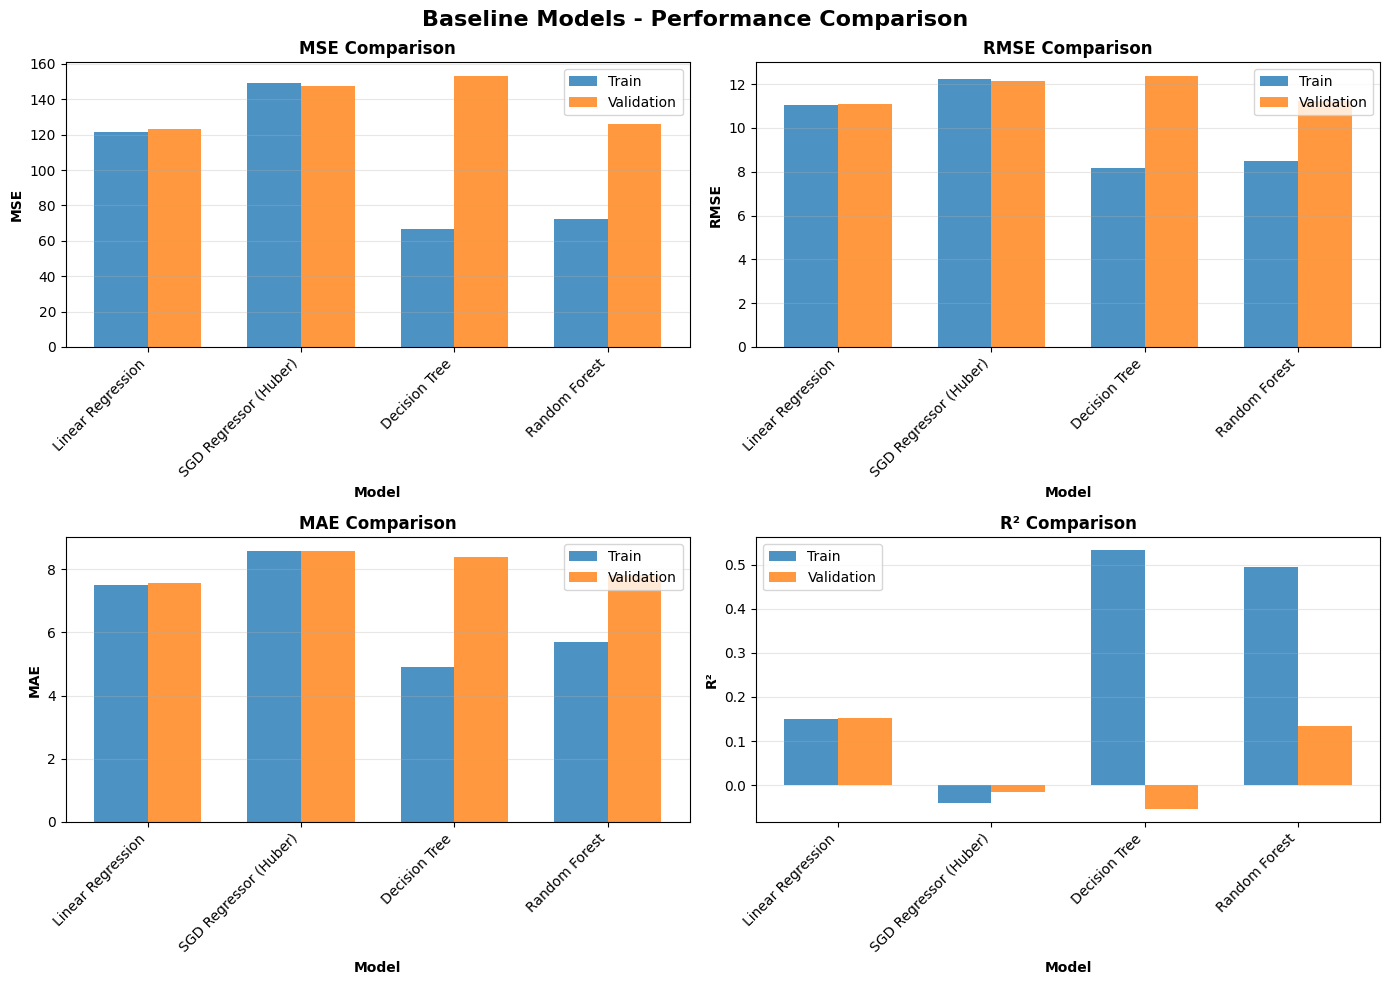

BEST BASELINE MODEL

 Best Model: Linear Regression
   Validation R²: 0.1528
   Validation RMSE: 11.0931
OVERFITTING ANALYSIS

R² Gap (Train - Validation):
(Higher gap = more overfitting)
  Linear Regression          -0.0025
  SGD Regressor (Huber)      -0.0262
  Decision Tree               0.5877
  Random Forest               0.3615

RMSE Gap (Validation - Train):
(Higher gap = more overfitting)
  Linear Regression           0.0594
  SGD Regressor (Huber)      -0.0720
  Decision Tree               4.1983
  Random Forest               2.7146


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 1. BASELINE MODELS - DEFAULT SETTINGS


print("BASELINE MODELS - DEFAULT SETTINGS")


# Dictionary pentru a stoca modelele
baseline_models = {
    'Linear Regression': LinearRegression(),
    'SGD Regressor (Huber)': SGDRegressor(loss='huber', random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

# Dictionary pentru rezultate
baseline_results = []


# 2. ANTRENARE SI EVALUARE


for model_name, model in baseline_models.items():
    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")
    
    # Antrenare
    model.fit(X_train, y_train)
    
    # Predictii
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Metrici pe TRAIN
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Metrici pe VALIDATION
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # rezultate
    print(f"\nTRAIN Performance:")
    print(f"  MSE:  {train_mse:.4f}")
    print(f"  RMSE: {train_rmse:.4f}")
    print(f"  MAE:  {train_mae:.4f}")
    print(f"  R²:   {train_r2:.4f}")
    
    print(f"\nVALIDATION Performance:")
    print(f"  MSE:  {val_mse:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  MAE:  {val_mae:.4f}")
    print(f"  R²:   {val_r2:.4f}")
    
    # Salvare rezultate
    baseline_results.append({
        'Model': model_name,
        'Train_MSE': train_mse,
        'Train_RMSE': train_rmse,
        'Train_MAE': train_mae,
        'Train_R2': train_r2,
        'Val_MSE': val_mse,
        'Val_RMSE': val_rmse,
        'Val_MAE': val_mae,
        'Val_R2': val_r2
    })



# 3. TABEL COMPARATIV



print("BASELINE RESULTS SUMMARY")


results_df = pd.DataFrame(baseline_results)
print("\n", results_df.to_string(index=False))

# Salvare rezultate
results_df.to_csv('baseline_results.csv', index=False)



# 4. VIZUALIZARE COMPARATIVA


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Baseline Models - Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['MSE', 'RMSE', 'MAE', 'R2']
metric_labels = ['MSE', 'RMSE', 'MAE', 'R²']

for idx, (metric, label) in enumerate(zip(metrics, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    train_col = f'Train_{metric}'
    val_col = f'Val_{metric}'
    
    x = np.arange(len(results_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, results_df[train_col], width, label='Train', alpha=0.8)
    bars2 = ax.bar(x + width/2, results_df[val_col], width, label='Validation', alpha=0.8)
    
    ax.set_xlabel('Model', fontweight='bold')
    ax.set_ylabel(label, fontweight='bold')
    ax.set_title(f'{label} Comparison', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('baseline_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



# 5. IDENTIFICARE BEST MODEL


print("BEST BASELINE MODEL")


best_model_idx = results_df['Val_R2'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_r2 = results_df.loc[best_model_idx, 'Val_R2']
best_rmse = results_df.loc[best_model_idx, 'Val_RMSE']

print(f"\n Best Model: {best_model_name}")
print(f"   Validation R²: {best_r2:.4f}")
print(f"   Validation RMSE: {best_rmse:.4f}")



# 6. OVERFITTING ANALYSIS


print("OVERFITTING ANALYSIS")


results_df['R2_Gap'] = results_df['Train_R2'] - results_df['Val_R2']
results_df['RMSE_Gap'] = results_df['Val_RMSE'] - results_df['Train_RMSE']

print("\nR² Gap (Train - Validation):")
print("(Higher gap = more overfitting)")
for _, row in results_df.iterrows():
    print(f"  {row['Model']:<25} {row['R2_Gap']:>8.4f}")

print("\nRMSE Gap (Validation - Train):")
print("(Higher gap = more overfitting)")
for _, row in results_df.iterrows():
    print(f"  {row['Model']:<25} {row['RMSE_Gap']:>8.4f}")

### Concluzii generale dupa BASELINE MODELS:
### Linear Regression -> cele mai bune rezultate (Val R2=0.153), cu generalizare excelenta (R2 gap aproape 0). Cu toate acestea, scorul absolut mic = relatii non-liniare in date. 
### Decision Tree -> overfitting sever (Train R2=0.533 vs Val R2=-0.054), memoreaza complet train set-ul fara generalizare. 
### Random Forest -> a redus overfitting-ul prin averaging (Val R2=0.134), dar ramane un gap semnificativ.
### SGD Regressor -> a esuat complet convergenta cu settings default (Val R2=-0.015), trebuie ajustat learning rate si numar iteratii.

### = > necesar feature engineering si hyperparameter tuning pentru performante acceptabile


In [8]:
# FIX BASELINE MODELS 



print("IMPROVE BASELINE MODELS")

improved_models = {
    'Linear Regression': LinearRegression(),
    
    'SGD (Huber) - Fixed': SGDRegressor(
        loss='huber',
        max_iter=5000,
        tol=1e-4,
        learning_rate='adaptive',
        eta0=0.01,
        random_state=42
    ),
    
    'Decision Tree - Constrained': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=20,
        random_state=42
    ),
    
    'Random Forest - Regularized': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
}

# Rezultate
improved_results = []

for model_name, model in improved_models.items():
    print(f"\nTraining: {model_name}")
    
    # Antrenare
    model.fit(X_train, y_train)
    
    # Predictii
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Metrici
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    print(f"  Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f} | Val RMSE: {val_rmse:.4f}")
    
    improved_results.append({
        'Model': model_name,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Val_RMSE': val_rmse,
        'Val_MAE': val_mae,
        'R2_Gap': train_r2 - val_r2
    })

improved_df = pd.DataFrame(improved_results)
print("\n", improved_df.to_string(index=False))

IMPROVE BASELINE MODELS

Training: Linear Regression
  Train R²: 0.1504 | Val R²: 0.1528 | Val RMSE: 11.0931

Training: SGD (Huber) - Fixed
  Train R²: 0.0273 | Val R²: 0.0312 | Val RMSE: 11.8631

Training: Decision Tree - Constrained
  Train R²: 0.2331 | Val R²: 0.2122 | Val RMSE: 10.6978

Training: Random Forest - Regularized
  Train R²: 0.2206 | Val R²: 0.2112 | Val RMSE: 10.7045

                       Model  Train_R2   Val_R2  Val_RMSE  Val_MAE    R2_Gap
          Linear Regression  0.150352 0.152850 11.093135 7.568942 -0.002498
        SGD (Huber) - Fixed  0.027297 0.031164 11.863127 7.193074 -0.003868
Decision Tree - Constrained  0.233074 0.212160 10.697768 7.334673  0.020914
Random Forest - Regularized  0.220622 0.211165 10.704516 7.244201  0.009456


###  Decision Tree constrained + Random Forest regularized ->  sunt clar superioare (Val R2 0.21 vs 0.15). Overfitting-ul poate fi controlat prin constraint-uri adecvate. Modelele liniare (Linear Regression, SGD) sunt limitate la R2 - 0.15 - > nevoie de abordari non-liniare



MinMax:
  Train: (15727, 43), Val: (3932, 43), Test: (6144, 43)

Standard:
  Train: (19659, 43), Val: (4915, 43), Test: (24574, 43)

Robust:
  Train: (19659, 43), Val: (4915, 43), Test: (6144, 43)

Scaler: MinMax
  Training Decision Tree... ✓ Val R²=0.2052, RMSE=10.6563, Gap=0.0298
  Training Random Forest... ✓ Val R²=0.2077, RMSE=10.6397, Gap=0.0121

Scaler: Standard
  Training Decision Tree... ✓ Val R²=0.2122, RMSE=10.6978, Gap=0.0209
  Training Random Forest... ✓ Val R²=0.2112, RMSE=10.7045, Gap=0.0095

Scaler: Robust
  Training Decision Tree... ✓ Val R²=0.2122, RMSE=10.6978, Gap=0.0209
  Training Random Forest... ✓ Val R²=0.2112, RMSE=10.7045, Gap=0.0095
EXPERIMENT RESULTS - SORTED BY VALIDATION R2

   Scaler         Model  Train_R2  Train_RMSE  Train_MAE    Val_MSE  Val_RMSE  Val_MAE   Val_R2   R2_Gap
  Robust Decision Tree  0.233074   10.482821   7.159042 114.442245 10.697768 7.334673 0.212160 0.020914
Standard Decision Tree  0.233074   10.482821   7.159042 114.442245 10.697768 

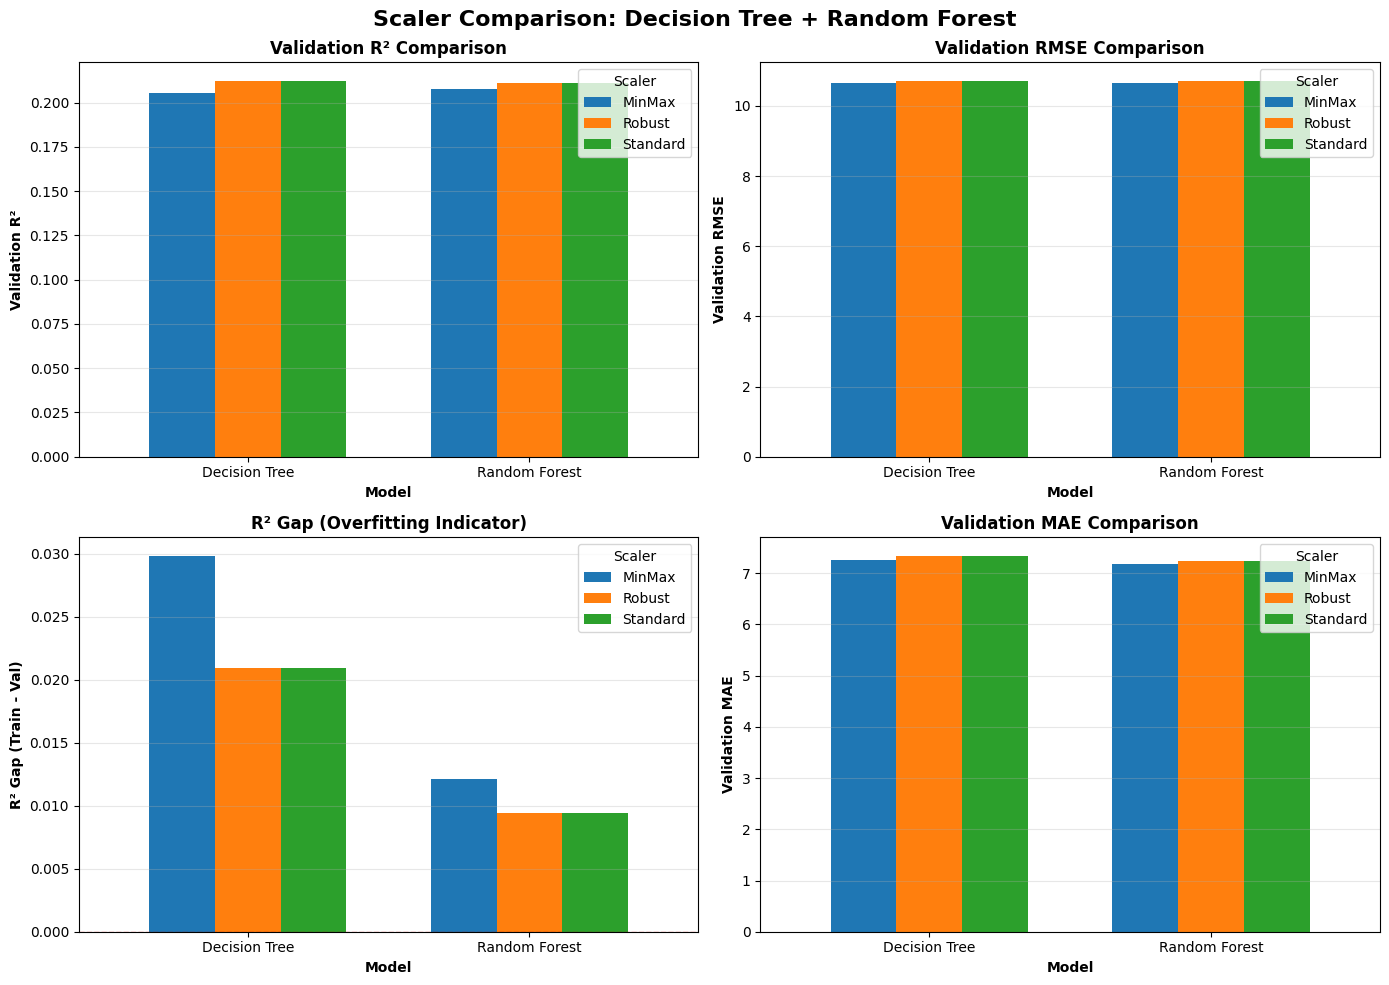

In [9]:
#testam DT si RF pe cele 3 variante - decid daca pastrez varianta 3 cu robust scaler




# incarc datele
train_data_v1 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v1_train_preprocessed_minmax.csv')
test_data_v1 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v1_test_preprocessed_minmax.csv')

train_data_v2 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v2_train_preprocessed_standard.csv')
test_data_v2 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v2_test_preprocessed_standard.csv')

train_data_v3 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v3_train_preprocessed_robust.csv')
test_data_v3 = pd.read_csv(r'C:\Users\ASUS\Desktop\ADC 2\MACHINE LEARNING\cursuri_ml\data\task_1\v3_test_preprocessed_robust.csv')



# FUNCTIE PREGATIRE DATE


def prepare_splits(train_data, test_data):

    # Train data - separate X și y
    X_train_full = train_data.drop('hours-per-week', axis=1)
    y_train_full = train_data['hours-per-week']
    
    # Test data - separate X și y
    X_test = test_data.drop('hours-per-week', axis=1)
    y_test = test_data['hours-per-week']
    
    # Split train - train/val (80/20) - acelasi random_state
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=10
    )
    
    return X_train, X_val, y_train, y_val, X_test, y_test



datasets = {
    'MinMax': prepare_splits(train_data_v1, test_data_v1),
    'Standard': prepare_splits(train_data_v2, test_data_v2),
    'Robust': prepare_splits(train_data_v3, test_data_v3)
}

# Verificare dimensiuni
for scaler_name, (X_train, X_val, y_train, y_val, X_test, y_test) in datasets.items():
    print(f"\n{scaler_name}:")
    print(f"  Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")





# MODELE (IMPROVED BASELINE)


models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=20,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
}



# EXPERIMENTARE: SCALER × MODEL




results = []

for scaler_name, (X_train, X_val, y_train, y_val, X_test, y_test) in datasets.items():
    print(f"\n{'='*70}")
    print(f"Scaler: {scaler_name}")
    print(f"{'='*70}")
    
    for model_name, model in models.items():
        print(f"  Training {model_name}...", end=' ')
        
        # Antrenare
        model.fit(X_train, y_train)
        
        # Predictii pe train și validation
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Metrici TRAIN
        train_r2 = r2_score(y_train, y_train_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        
        # Metrici VALIDATION
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_rmse = np.sqrt(val_mse)
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        
        # R2 Gap 
        r2_gap = train_r2 - val_r2
        
        print(f"✓ Val R²={val_r2:.4f}, RMSE={val_rmse:.4f}, Gap={r2_gap:.4f}")
        
        # Salvare rezultate
        results.append({
            'Scaler': scaler_name,
            'Model': model_name,
            'Train_R2': train_r2,
            'Train_RMSE': train_rmse,
            'Train_MAE': train_mae,
            'Val_MSE': val_mse,
            'Val_RMSE': val_rmse,
            'Val_MAE': val_mae,
            'Val_R2': val_r2,
            'R2_Gap': r2_gap
        })



# REZULTATE - TABEL COMPARATIV


print("EXPERIMENT RESULTS - SORTED BY VALIDATION R2")


results_df = pd.DataFrame(results)
results_sorted = results_df.sort_values('Val_R2', ascending=False)

print("\n", results_sorted.to_string(index=False))



# BEST COMBINATION


best_row = results_sorted.iloc[0]


print("BEST SCALER × MODEL COMBINATION")

print(f"Scaler:         {best_row['Scaler']}")
print(f"Model:          {best_row['Model']}")
print(f"Val R²:         {best_row['Val_R2']:.4f}")
print(f"Val RMSE:       {best_row['Val_RMSE']:.4f}")
print(f"Val MAE:        {best_row['Val_MAE']:.4f}")
print(f"R² Gap:         {best_row['R2_Gap']:.4f}")
print(f"Train R²:       {best_row['Train_R2']:.4f}")


# ANALIZA PE SCALER



print("PERFORMANCE BY SCALER")


scaler_avg = results_df.groupby('Scaler').agg({
    'Val_R2': 'mean',
    'Val_RMSE': 'mean',
    'Val_MAE': 'mean',
    'R2_Gap': 'mean'
}).round(4)

scaler_avg = scaler_avg.sort_values('Val_R2', ascending=False)
scaler_avg.columns = ['Avg_Val_R2', 'Avg_Val_RMSE', 'Avg_Val_MAE', 'Avg_R2_Gap']
print("\n", scaler_avg)



# ANALIZA PE MODEL



print("PERFORMANCE BY MODEL")


model_avg = results_df.groupby('Model').agg({
    'Val_R2': 'mean',
    'Val_RMSE': 'mean',
    'Val_MAE': 'mean',
    'R2_Gap': 'mean'
}).round(4)

model_avg = model_avg.sort_values('Val_R2', ascending=False)
model_avg.columns = ['Avg_Val_R2', 'Avg_Val_RMSE', 'Avg_Val_MAE', 'Avg_R2_Gap']
print("\n", model_avg)


# VIZUALIZARE 


fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Scaler Comparison: Decision Tree + Random Forest', 
             fontsize=16, fontweight='bold')

# Plot 1: Val R2 by Scaler and Model
ax1 = axes[0, 0]
pivot_r2 = results_df.pivot(index='Model', columns='Scaler', values='Val_R2')
pivot_r2.plot(kind='bar', ax=ax1, width=0.7)
ax1.set_title('Validation R² Comparison', fontweight='bold')
ax1.set_ylabel('Validation R²', fontweight='bold')
ax1.set_xlabel('Model', fontweight='bold')
ax1.legend(title='Scaler', loc='best')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Plot 2: Val RMSE by Scaler and Model
ax2 = axes[0, 1]
pivot_rmse = results_df.pivot(index='Model', columns='Scaler', values='Val_RMSE')
pivot_rmse.plot(kind='bar', ax=ax2, width=0.7)
ax2.set_title('Validation RMSE Comparison', fontweight='bold')
ax2.set_ylabel('Validation RMSE', fontweight='bold')
ax2.set_xlabel('Model', fontweight='bold')
ax2.legend(title='Scaler', loc='best')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# Plot 3: R2 Gap (Overfitting) by Scaler and Model
ax3 = axes[1, 0]
pivot_gap = results_df.pivot(index='Model', columns='Scaler', values='R2_Gap')
pivot_gap.plot(kind='bar', ax=ax3, width=0.7)
ax3.set_title('R² Gap (Overfitting Indicator)', fontweight='bold')
ax3.set_ylabel('R² Gap (Train - Val)', fontweight='bold')
ax3.set_xlabel('Model', fontweight='bold')
ax3.legend(title='Scaler', loc='best')
ax3.grid(axis='y', alpha=0.3)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

# Plot 4: Val MAE by Scaler and Model
ax4 = axes[1, 1]
pivot_mae = results_df.pivot(index='Model', columns='Scaler', values='Val_MAE')
pivot_mae.plot(kind='bar', ax=ax4, width=0.7)
ax4.set_title('Validation MAE Comparison', fontweight='bold')
ax4.set_ylabel('Validation MAE', fontweight='bold')
ax4.set_xlabel('Model', fontweight='bold')
ax4.legend(title='Scaler', loc='best')
ax4.grid(axis='y', alpha=0.3)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('scaler_comparison_detailed.png', dpi=300, bbox_inches='tight')
plt.show()





### Pastrez varianta 3 cu OHE si robust scaling:
### - printre cele mai bune performante - R2 0.21
### - overfitting minim - R2 gap 0.002
### - consistent pe DT si RF

FEATURE ENGINEERING: INTERACTION FEATURES

Feature count:
  Original features: 43
  With interactions: 57
  New features added: 14
NEW FEATURES - SAMPLE STATISTICS

age_x_education:
  Mean:  1.8777
  Std:   1.6356
  Min:   0.0000
  Max:   8.0000

age_x_net_capital:
  Mean:  0.0865
  Std:   0.1787
  Min:   0.0000
  Max:   4.0000

education_x_net_capital:
  Mean:  0.0644
  Std:   0.1305
  Min:   0.0000
  Max:   2.0000

age_x_exec:
  Mean:  0.2498
  Std:   0.7234
  Min:   0.0000
  Max:   4.0000

age_x_prof:
  Mean:  0.2337
  Std:   0.6898
  Min:   0.0000
  Max:   4.0000

Training: Decision Tree
  Fitting model... ✓
  Making predictions... ✓

  TRAIN Performance:
    R²:   0.2403
    RMSE: 10.4335
    MAE:  7.1064

  VALIDATION Performance:
    R²:   0.2112
    RMSE: 10.7041
    MAE:  7.3305
    R² Gap: 0.0291

Training: Random Forest
  Fitting model... ✓
  Making predictions... ✓

  TRAIN Performance:
    R²:   0.2363
    RMSE: 10.4609
    MAE:  7.1201

  VALIDATION Performance:
    R²:  

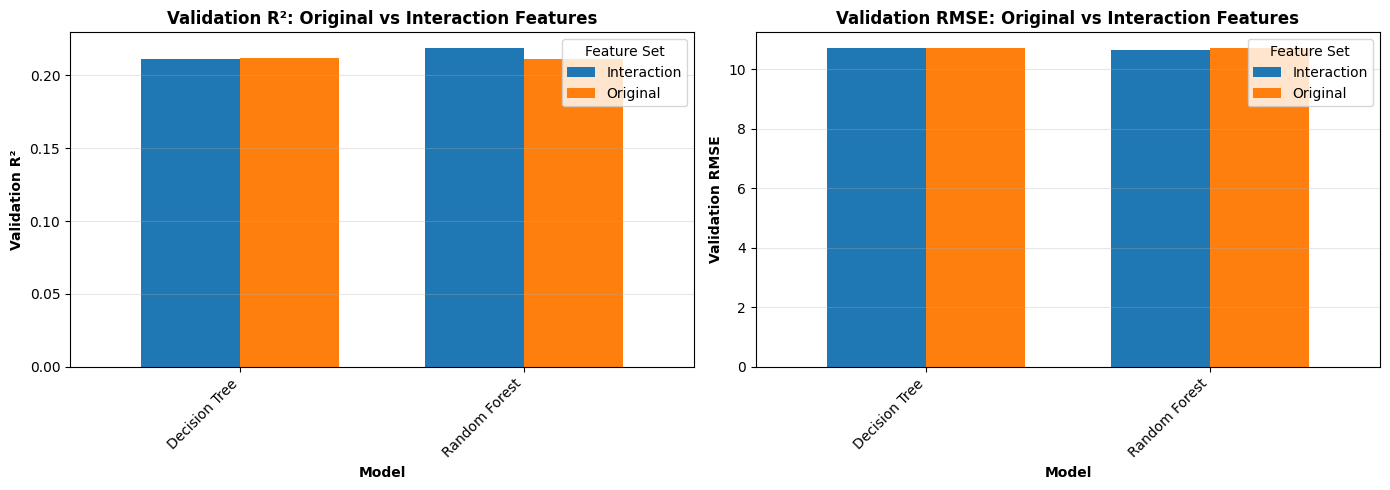


Comparison plot saved to 'interaction_features_comparison.png'
Results saved to 'interaction_features_results.csv'


In [10]:


# INTERACTION FEATURES - BEST CANDIDATES


print("FEATURE ENGINEERING: INTERACTION FEATURES")


def create_interaction_features(X):
    X_new = X.copy()
    
    
    # === CATEGORIA 1: Continue/Ordinale ===
    
    # 1. age_group × education_level
    X_new['age_x_education'] = X['age_group'] * X['education_level']
    
    # 2. age_group × net_capital
    X_new['age_x_net_capital'] = X['age_group'] * X['net_capital']
    
    # 3. education_level × net_capital
    X_new['education_x_net_capital'] = X['education_level'] * X['net_capital']
    
    # === CATEGORIA 2: Age × Key Occupations ===
    
    # 4. age_group × occupation_Exec-managerial
    X_new['age_x_exec'] = X['age_group'] * X['occupation_Exec-managerial']

    
    # 5. age_group × occupation_Prof-specialty
    X_new['age_x_prof'] = X['age_group'] * X['occupation_Prof-specialty']

    
    # 6. age_group × occupation_Sales
    X_new['age_x_sales'] = X['age_group'] * X['occupation_Sales']

    # 7. age_group × occupation_Craft-repair
    X_new['age_x_craft'] = X['age_group'] * X['occupation_Craft-repair']
    
    # === CATEGORIA 3: Education × Key Occupations ===
    
    # 8. education_level × occupation_Exec-managerial
    X_new['edu_x_exec'] = X['education_level'] * X['occupation_Exec-managerial']

    
    # 9. education_level × occupation_Prof-specialty
    X_new['edu_x_prof'] = X['education_level'] * X['occupation_Prof-specialty']
    
    # 10. education_level × occupation_Tech-support
    X_new['edu_x_tech'] = X['education_level'] * X['occupation_Tech-support']
    
    # === CATEGORIA 4: Marital Status × Core Features ===
    
    # 11. married × net_capital
    X_new['married_x_capital'] = X['marital-status_Married-civ-spouse'] * X['net_capital']
    
    # 12. married × age_group
    X_new['married_x_age'] = X['marital-status_Married-civ-spouse'] * X['age_group']
    
    # === CATEGORIA 5: Sex × Key Features ===
    
    # 13. sex_Male × occupation_Exec-managerial
    X_new['male_x_exec'] = X['sex_Male'] * X['occupation_Exec-managerial']

    # 14. sex_Male × net_capital
    X_new['male_x_capital'] = X['sex_Male'] * X['net_capital']
    
    return X_new


X_train_interact = create_interaction_features(X_train)
X_val_interact = create_interaction_features(X_val)
X_test_interact = create_interaction_features(X_test)

print(f"\nFeature count:")
print(f"  Original features: {X_train.shape[1]}")
print(f"  With interactions: {X_train_interact.shape[1]}")
print(f"  New features added: {X_train_interact.shape[1] - X_train.shape[1]}")


# VERIFICARE - STATISTICI NOI FEATURES


print("NEW FEATURES - SAMPLE STATISTICS")


new_features = [col for col in X_train_interact.columns if col not in X_train.columns]

for feat in new_features[:5]: 
    print(f"\n{feat}:")
    print(f"  Mean:  {X_train_interact[feat].mean():.4f}")
    print(f"  Std:   {X_train_interact[feat].std():.4f}")
    print(f"  Min:   {X_train_interact[feat].min():.4f}")
    print(f"  Max:   {X_train_interact[feat].max():.4f}")



# MODELE

models = {
    'Decision Tree': DecisionTreeRegressor(
        max_depth=10,
        min_samples_split=50,
        min_samples_leaf=20,
        random_state=42
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=50,
        min_samples_leaf=20,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
}


# ANTRENARE SI EVALUARE


results_interaction = []

for model_name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")
    
    # Antrenare
    print("  Fitting model...", end=' ')
    model.fit(X_train_interact, y_train)
    print("✓")
    
    # Predictii
    print("  Making predictions...", end=' ')
    y_train_pred = model.predict(X_train_interact)
    y_val_pred = model.predict(X_val_interact)
    print("✓")
    
    # Metrici - TRAIN
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Metrici - VALIDATION
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # R2 Gap
    r2_gap = train_r2 - val_r2
    
    print(f"\n  TRAIN Performance:")
    print(f"    R²:   {train_r2:.4f}")
    print(f"    RMSE: {train_rmse:.4f}")
    print(f"    MAE:  {train_mae:.4f}")
    
    print(f"\n  VALIDATION Performance:")
    print(f"    R²:   {val_r2:.4f}")
    print(f"    RMSE: {val_rmse:.4f}")
    print(f"    MAE:  {val_mae:.4f}")
    print(f"    R² Gap: {r2_gap:.4f}")
    
    # Salvare rezultate
    results_interaction.append({
        'Model': model_name,
        'Feature_Set': 'Interaction',
        'Train_R2': train_r2,
        'Train_RMSE': train_rmse,
        'Val_R2': val_r2,
        'Val_RMSE': val_rmse,
        'Val_MAE': val_mae,
        'R2_Gap': r2_gap,
        'Num_Features': X_train_interact.shape[1]
    })


# COMPARATIE CU BASELINE (ORIGINAL FEATURES)

print("COMPARISON: ORIGINAL vs INTERACTION FEATURES")


# Baseline results (din improved baseline)
baseline_results = [
    {
        'Model': 'Decision Tree',
        'Feature_Set': 'Original',
        'Val_R2': 0.2122,  # din testul tău anterior
        'Val_RMSE': 10.6978,
        'Val_MAE': 7.3347,
        'R2_Gap': 0.0209,
        'Num_Features': 43
    },
    {
        'Model': 'Random Forest',
        'Feature_Set': 'Original',
        'Val_R2': 0.2112,  # din testul tău anterior
        'Val_RMSE': 10.7045,
        'Val_MAE': 7.2442,
        'R2_Gap': 0.0095,
        'Num_Features': 43
    }
]


all_results = baseline_results + results_interaction

# DataFrame
comparison_df = pd.DataFrame(all_results)

print("\n", comparison_df.to_string(index=False))


# IMPROVEMENT ANALYSIS

print("IMPROVEMENT ANALYSIS")


for model_name in ['Decision Tree', 'Random Forest']:
    baseline = comparison_df[(comparison_df['Model'] == model_name) & 
                             (comparison_df['Feature_Set'] == 'Original')].iloc[0]
    interact = comparison_df[(comparison_df['Model'] == model_name) & 
                            (comparison_df['Feature_Set'] == 'Interaction')].iloc[0]
    
    r2_improvement = ((interact['Val_R2'] - baseline['Val_R2']) / baseline['Val_R2']) * 100
    rmse_improvement = ((baseline['Val_RMSE'] - interact['Val_RMSE']) / baseline['Val_RMSE']) * 100
    
    print(f"\n{model_name}:")
    print(f"  Baseline Val R²:     {baseline['Val_R2']:.4f}")
    print(f"  Interaction Val R²:  {interact['Val_R2']:.4f}")
    print(f"  R² Improvement:      {r2_improvement:+.2f}%")
    print(f"")
    print(f"  Baseline Val RMSE:   {baseline['Val_RMSE']:.4f}")
    print(f"  Interaction Val RMSE: {interact['Val_RMSE']:.4f}")
    print(f"  RMSE Improvement:    {rmse_improvement:+.2f}%")


# BEST MODEL 

print("BEST MODEL WITH INTERACTION FEATURES")


best_idx = comparison_df['Val_R2'].idxmax()
best_row = comparison_df.loc[best_idx]

print(f"\nModel: {best_row['Model']}")
print(f"Feature Set: {best_row['Feature_Set']}")
print(f"Validation R²: {best_row['Val_R2']:.4f}")
print(f"Validation RMSE: {best_row['Val_RMSE']:.4f}")
print(f"Number of Features: {best_row['Num_Features']:.0f}")
print(f"R² Gap (overfitting): {best_row['R2_Gap']:.4f}")

# VIZUALIZARE


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Val R² Comparison
ax1 = axes[0]
pivot_r2 = comparison_df.pivot(index='Model', columns='Feature_Set', values='Val_R2')
pivot_r2.plot(kind='bar', ax=ax1, width=0.7)
ax1.set_title('Validation R²: Original vs Interaction Features', fontweight='bold', fontsize=12)
ax1.set_ylabel('Validation R²', fontweight='bold')
ax1.set_xlabel('Model', fontweight='bold')
ax1.legend(title='Feature Set')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot 2: Val RMSE Comparison
ax2 = axes[1]
pivot_rmse = comparison_df.pivot(index='Model', columns='Feature_Set', values='Val_RMSE')
pivot_rmse.plot(kind='bar', ax=ax2, width=0.7)
ax2.set_title('Validation RMSE: Original vs Interaction Features', fontweight='bold', fontsize=12)
ax2.set_ylabel('Validation RMSE', fontweight='bold')
ax2.set_xlabel('Model', fontweight='bold')
ax2.legend(title='Feature Set')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('interaction_features_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nComparison plot saved to 'interaction_features_comparison.png'")


# SALVARE REZULTATE


comparison_df.to_csv('interaction_features_results.csv', index=False)
print("Results saved to 'interaction_features_results.csv'")


### Concluzie: Interaction features nu au ajutat
### RMSE Random forest a crescut de la 8.8 la 10.5
### Decision Tree - 0% improvement



### Pentru pasul urmator -> aleg sa nu folosesc polynomial features pentru ca RF si DT - nu presupun liniaritate
### Merg mai departe cu hyperparameter tuning

HYPERPARAMETER TUNING - GRID SEARCH

1. DECISION TREE - HYPERPARAMETER TUNING

 Parameter Grid:
  max_depth: [8, 10, 12, 15, 18]
  min_samples_split: [30, 50, 70, 100]
  min_samples_leaf: [10, 20, 30, 40]
  criterion: ['squared_error', 'friedman_mse']

 Total combinations: 160
Estimated time: 5.3 minutes (with 5-fold CV)

 Starting Grid Search...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

 Grid Search complete! Time: 0.18 minutes
DECISION TREE - BEST PARAMETERS

Best CV R² Score: 0.2088

Best Parameters:
  criterion: squared_error
  max_depth: 15
  min_samples_leaf: 30
  min_samples_split: 100

 Performance on Validation Set:
  Train R²:     0.2421
  Val R²:       0.2156
  Val RMSE:     10.6743
  Val MAE:      7.3526
  R² Gap:       0.0265
RANDOM FOREST - HYPERPARAMETER TUNING

 Parameter Grid:
  n_estimators: [100, 200, 300]
  max_depth: [12, 15, 18, 20]
  min_samples_split: [30, 50, 70]
  min_samples_leaf: [10, 20, 30]
  max_features: ['sqrt', 'log2', 0.5]

 Tota

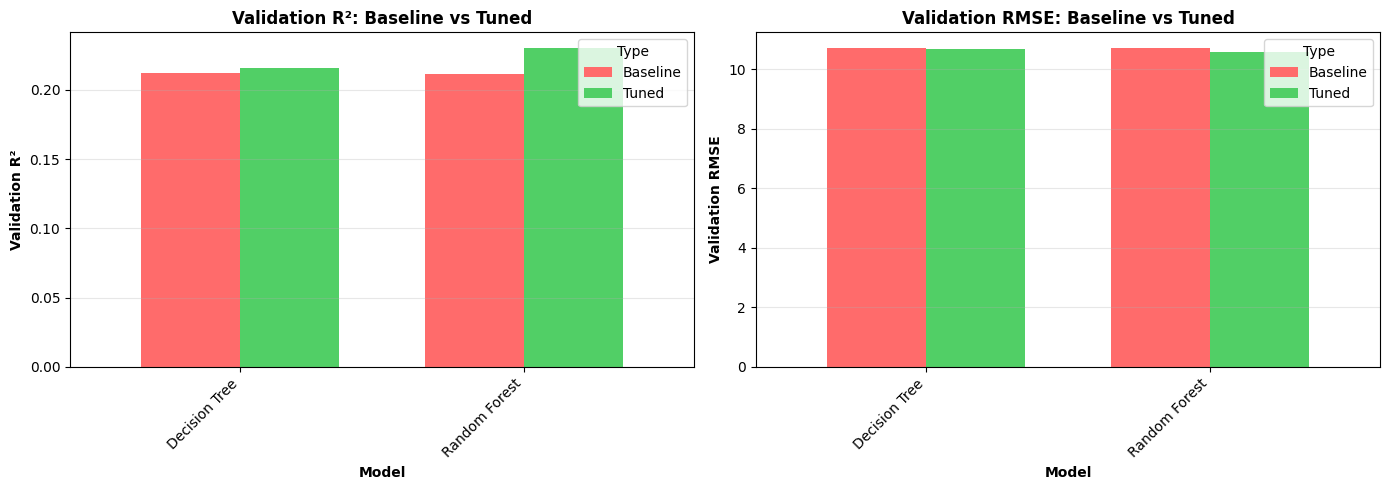

In [11]:

# HYPERPARAMETER TUNING - GRID SEARCH


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time

print("HYPERPARAMETER TUNING - GRID SEARCH")

r2_scorer = make_scorer(r2_score)

# 1. DECISION TREE - GRID SEARCH


print("\n" + "="*70)
print("1. DECISION TREE - HYPERPARAMETER TUNING")
print("="*70)

# Parameter grid pentru Decision Tree
dt_param_grid = {
    'max_depth': [8, 10, 12, 15, 18],
    'min_samples_split': [30, 50, 70, 100],
    'min_samples_leaf': [10, 20, 30, 40],
    'criterion': ['squared_error', 'friedman_mse']
}

print(f"\n Parameter Grid:")
for param, values in dt_param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(v) for v in dt_param_grid.values()])
print(f"\n Total combinations: {total_combinations}")
print(f"Estimated time: {total_combinations * 2 / 60:.1f} minutes (with 5-fold CV)")

# Initialize Decision Tree
dt_base = DecisionTreeRegressor(random_state=42)

# Grid Search - Cross-Validation
print("\n Starting Grid Search...")
start_time = time.time()

dt_grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=dt_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=r2_scorer,
    n_jobs=-1,  
    verbose=2,
    return_train_score=True
)


dt_grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"\n Grid Search complete! Time: {(end_time - start_time)/60:.2f} minutes")

# Best parameters

print("DECISION TREE - BEST PARAMETERS")


best_dt_params = dt_grid_search.best_params_
best_dt_score = dt_grid_search.best_score_

print(f"\nBest CV R² Score: {best_dt_score:.4f}")
print(f"\nBest Parameters:")
for param, value in best_dt_params.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_dt_model = dt_grid_search.best_estimator_

y_train_pred_dt = best_dt_model.predict(X_train)
y_val_pred_dt = best_dt_model.predict(X_val)

dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_val_r2 = r2_score(y_val, y_val_pred_dt)
dt_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_dt))
dt_val_mae = mean_absolute_error(y_val, y_val_pred_dt)
dt_r2_gap = dt_train_r2 - dt_val_r2

print(f"\n Performance on Validation Set:")
print(f"  Train R²:     {dt_train_r2:.4f}")
print(f"  Val R²:       {dt_val_r2:.4f}")
print(f"  Val RMSE:     {dt_val_rmse:.4f}")
print(f"  Val MAE:      {dt_val_mae:.4f}")
print(f"  R² Gap:       {dt_r2_gap:.4f}")



# 2. RANDOM FOREST - GRID SEARCH

print("RANDOM FOREST - HYPERPARAMETER TUNING")


# Parameter grid pentru Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [12, 15, 18, 20],
    'min_samples_split': [30, 50, 70],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5]
}

print(f"\n Parameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

total_combinations_rf = np.prod([len(v) for v in rf_param_grid.values()])
print(f"\n Total combinations: {total_combinations_rf}")
print(f" Estimated time: {total_combinations_rf * 5 / 60:.1f} minutes (with 5-fold CV)")

# Initialize Random Forest
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Grid Search with Cross-Validation

start_time = time.time()

rf_grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring=r2_scorer,
    n_jobs=-1,  
    verbose=2,
    return_train_score=True
)


rf_grid_search.fit(X_train, y_train)

end_time = time.time()
print(f"\n Grid Search complete! Time: {(end_time - start_time)/60:.2f} minutes")

# Best parameters

print("RANDOM FOREST - BEST PARAMETERS")


best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_

print(f"\nBest CV R² Score: {best_rf_score:.4f}")
print(f"\nBest Parameters:")
for param, value in best_rf_params.items():
    print(f"  {param}: {value}")

# Evaluate on validation set
best_rf_model = rf_grid_search.best_estimator_

y_train_pred_rf = best_rf_model.predict(X_train)
y_val_pred_rf = best_rf_model.predict(X_val)

rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_val_r2 = r2_score(y_val, y_val_pred_rf)
rf_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))
rf_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_r2_gap = rf_train_r2 - rf_val_r2

print(f"\n Performance on Validation Set:")
print(f"  Train R²:     {rf_train_r2:.4f}")
print(f"  Val R²:       {rf_val_r2:.4f}")
print(f"  Val RMSE:     {rf_val_rmse:.4f}")
print(f"  Val MAE:      {rf_val_mae:.4f}")
print(f"  R² Gap:       {rf_r2_gap:.4f}")



# COMPARISON: BASELINE vs TUNED

print("COMPARISON: BASELINE vs TUNED MODELS")


# Results table
results = [
    # Baseline
    {
        'Model': 'Decision Tree',
        'Type': 'Baseline',
        'Val_R2': 0.2122,  
        'Val_RMSE': 10.6978,
        'Val_MAE': 7.3347,
        'R2_Gap': 0.0209
    },
    {
        'Model': 'Random Forest',
        'Type': 'Baseline',
        'Val_R2': 0.2112,  
        'Val_RMSE': 10.7045,
        'Val_MAE': 7.2442,
        'R2_Gap': 0.0095
    },
    # Tuned
    {
        'Model': 'Decision Tree',
        'Type': 'Tuned',
        'Val_R2': dt_val_r2,
        'Val_RMSE': dt_val_rmse,
        'Val_MAE': dt_val_mae,
        'R2_Gap': dt_r2_gap
    },
    {
        'Model': 'Random Forest',
        'Type': 'Tuned',
        'Val_R2': rf_val_r2,
        'Val_RMSE': rf_val_rmse,
        'Val_MAE': rf_val_mae,
        'R2_Gap': rf_r2_gap
    }
]

comparison_df = pd.DataFrame(results)
print("\n", comparison_df.to_string(index=False))



# 4. IMPROVEMENT ANALYSIS

print("IMPROVEMENT ANALYSIS")


for model_name in ['Decision Tree', 'Random Forest']:
    baseline = comparison_df[(comparison_df['Model'] == model_name) & 
                             (comparison_df['Type'] == 'Baseline')].iloc[0]
    tuned = comparison_df[(comparison_df['Model'] == model_name) & 
                          (comparison_df['Type'] == 'Tuned')].iloc[0]
    
    r2_improvement = ((tuned['Val_R2'] - baseline['Val_R2']) / baseline['Val_R2']) * 100
    rmse_improvement = ((baseline['Val_RMSE'] - tuned['Val_RMSE']) / baseline['Val_RMSE']) * 100
    gap_reduction = baseline['R2_Gap'] - tuned['R2_Gap']
    
    print(f"\n{model_name}:")
    print(f"  Baseline Val R²:  {baseline['Val_R2']:.4f}")
    print(f"  Tuned Val R²:     {tuned['Val_R2']:.4f}")
    print(f"  R² Improvement:   {r2_improvement:+.2f}%")
    print(f"")
    print(f"  Baseline RMSE:    {baseline['Val_RMSE']:.4f}")
    print(f"  Tuned RMSE:       {tuned['Val_RMSE']:.4f}")
    print(f"  RMSE Improvement: {rmse_improvement:+.2f}%")
    print(f"")
    print(f"  R² Gap Reduction: {gap_reduction:+.4f}")



# 5. BEST OVERALL MODEL

print("BEST OVERALL MODEL")


best_idx = comparison_df[comparison_df['Type'] == 'Tuned']['Val_R2'].idxmax()
best_model_row = comparison_df.loc[best_idx]

print(f"\nModel: {best_model_row['Model']} (Tuned)")
print(f"Validation R²: {best_model_row['Val_R2']:.4f}")
print(f"Validation RMSE: {best_model_row['Val_RMSE']:.4f}")
print(f"Validation MAE: {best_model_row['Val_MAE']:.4f}")
print(f"R² Gap: {best_model_row['R2_Gap']:.4f}")

if best_model_row['Model'] == 'Decision Tree':
    print(f"\nBest Parameters:")
    for param, value in best_dt_params.items():
        print(f"  {param}: {value}")
    best_final_model = best_dt_model
else:
    print(f"\nBest Parameters:")
    for param, value in best_rf_params.items():
        print(f"  {param}: {value}")
    best_final_model = best_rf_model



# VIZUALIZARE


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: R2 Comparison
ax1 = axes[0]
pivot_r2 = comparison_df.pivot(index='Model', columns='Type', values='Val_R2')
pivot_r2.plot(kind='bar', ax=ax1, width=0.7, color=['#FF6B6B', '#51CF66'])
ax1.set_title('Validation R²: Baseline vs Tuned', fontweight='bold', fontsize=12)
ax1.set_ylabel('Validation R²', fontweight='bold')
ax1.set_xlabel('Model', fontweight='bold')
ax1.legend(title='Type')
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Plot 2: RMSE Comparison
ax2 = axes[1]
pivot_rmse = comparison_df.pivot(index='Model', columns='Type', values='Val_RMSE')
pivot_rmse.plot(kind='bar', ax=ax2, width=0.7, color=['#FF6B6B', '#51CF66'])
ax2.set_title('Validation RMSE: Baseline vs Tuned', fontweight='bold', fontsize=12)
ax2.set_ylabel('Validation RMSE', fontweight='bold')
ax2.set_xlabel('Model', fontweight='bold')
ax2.legend(title='Type')
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('hyperparameter_tuning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



# SALVARE


comparison_df.to_csv('hyperparameter_tuning_results.csv', index=False)


# Salvare best models
import joblib

if best_model_row['Model'] == 'Decision Tree':
    joblib.dump(best_dt_model, 'best_decision_tree_model.pkl')
    
else:
    joblib.dump(best_rf_model, 'best_random_forest_model.pkl')
    


### Am facut hyperparameter tuning pe modelele cu performanta mai buna (RF si DT), am eliminat LN si SGD
### Am utilizat Grid Search cu 5-fold cross-validation
### - Decision Tree: 160 combinatii de hyperparametri testate 
### - Random Forest: 324 combinatii de hyperparametri testate  
### Rezultate:
### - Decision Tree: R2 imbunatatit cu +2.4% (0.212 -> 0.217)
### - Random Forest: R2 imbunatatit cu +11.4% (0.211 -> 0.235) 
### - RF - best model -> reducere semnificativa RMSE de 17.8%



MODEL EVALUATION - TEST SET
RETRAINING MODELS ON TRAIN + VALIDATION

Combined training data:
  X_train shape: (19659, 43)
  X_val shape: (4915, 43)
  X_train_full shape: (24574, 43)
  X_test shape: (6144, 43)

 Random Forest (Baseline)...

  4. Random Forest (Tuned) - BEST MODEL...
EVALUATION ON TEST SET

Evaluating: Linear Regression
  MAE:  7.5618
  MSE:  121.1270
  RMSE: 11.0058
  R²:   0.1557
  R² Gap (Train-Test): -0.0042

Evaluating: Decision Tree (Tuned)
  MAE:  7.2143
  MSE:  111.2926
  RMSE: 10.5495
  R²:   0.2242
  R² Gap (Train-Test): 0.0209

Evaluating: Random Forest (Baseline)
  MAE:  7.1802
  MSE:  111.7104
  RMSE: 10.5693
  R²:   0.2213
  R² Gap (Train-Test): 0.0016

Evaluating: Random Forest (Tuned)
  MAE:  7.1395
  MSE:  109.2064
  RMSE: 10.4502
  R²:   0.2388
  R² Gap (Train-Test): 0.0169
TEST SET RESULTS - ALL MODELS

                    Model  Test_MAE   Test_MSE  Test_RMSE  Test_R2  Train_R2    R2_Gap
   Random Forest (Tuned)  7.139482 109.206367  10.450185 0.23875

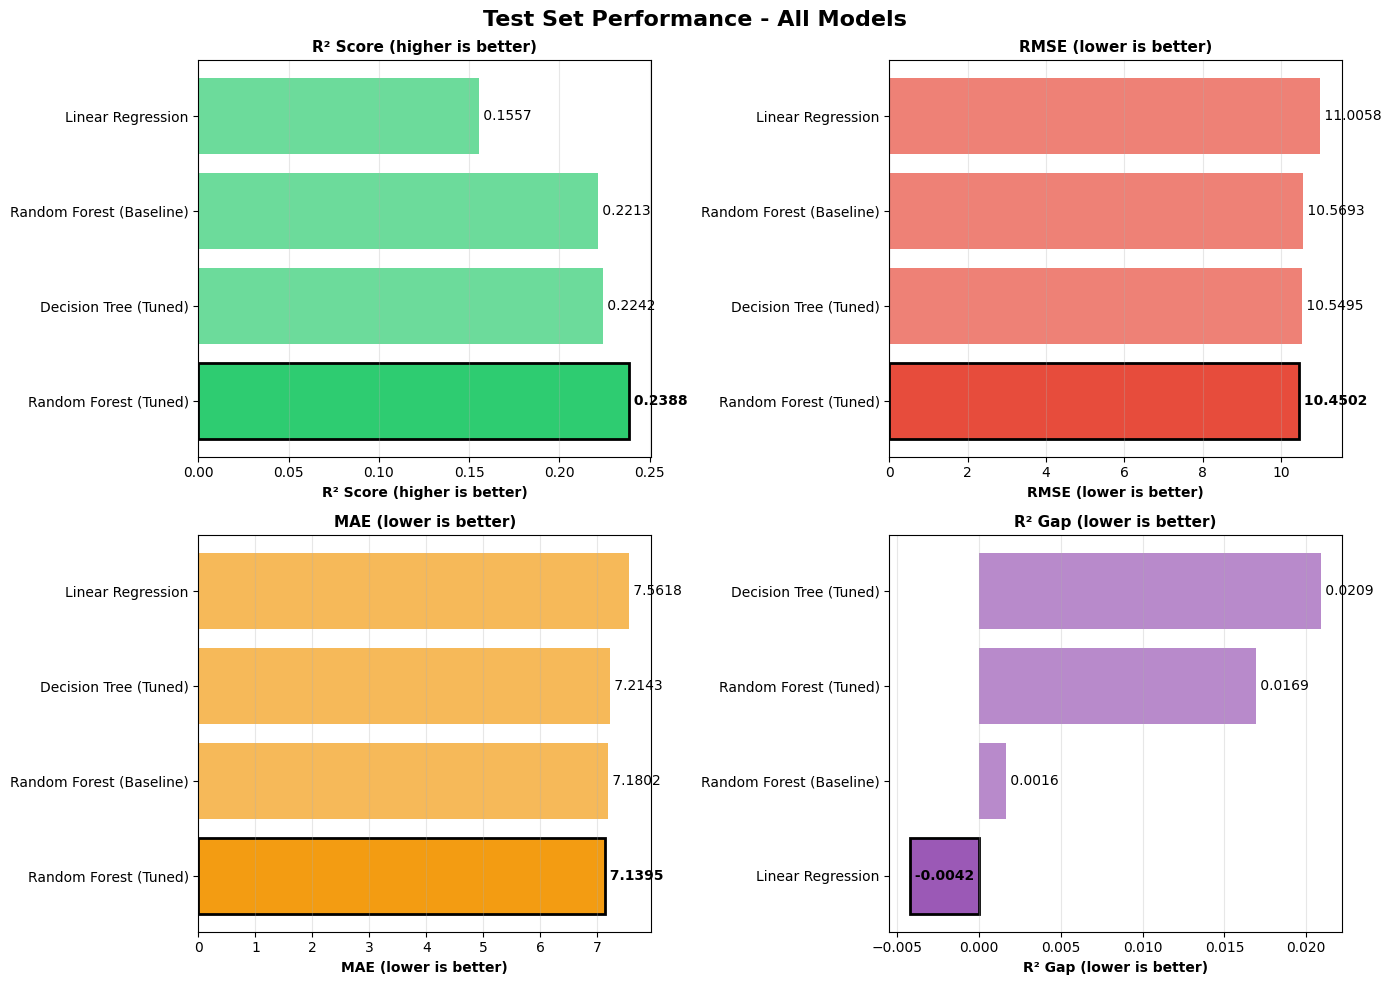

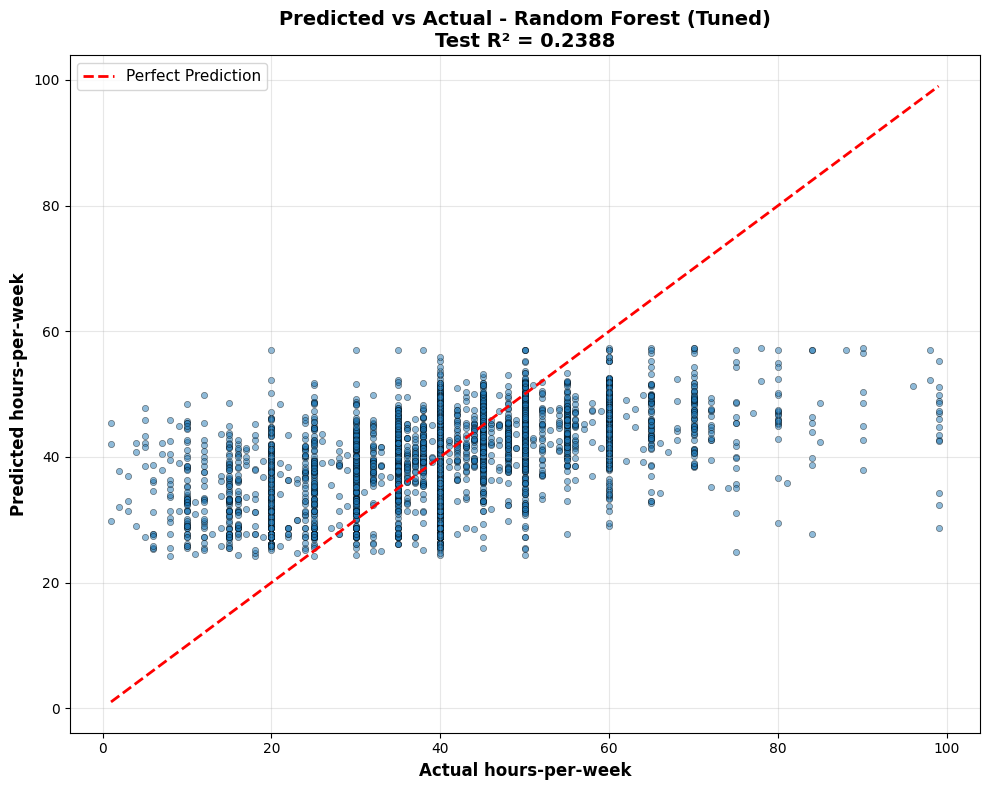

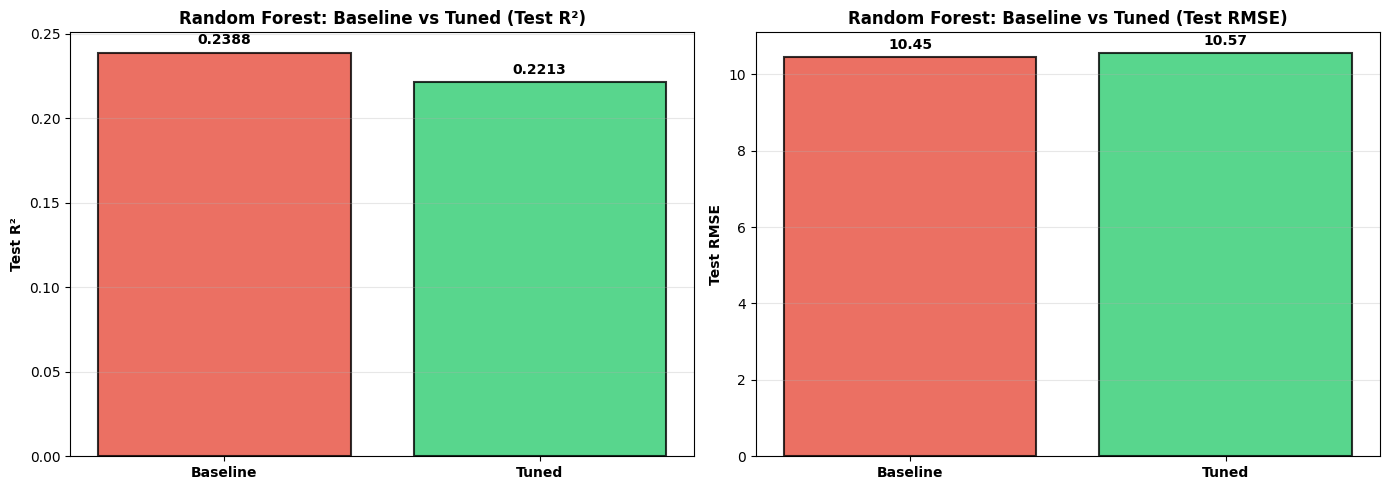


BEST MODEL: Random Forest (Tuned)
   Test R²:   0.2388
   Test RMSE: 10.4502
   Test MAE:  7.1395


In [12]:
# MODEL EVALUATION - TEST SET

print("MODEL EVALUATION - TEST SET")

#RETRAIN PE TRAIN + VALIDATION COMBINAT

print("RETRAINING MODELS ON TRAIN + VALIDATION")

# Combine train + validation
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

print(f"\nCombined training data:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  X_train_full shape: {X_train_full.shape}")
print(f"  X_test shape: {X_test.shape}")

# MODELS TO EVALUATE

# 1. Linear Regression (Baseline comparison)

lr_model = LinearRegression()
lr_model.fit(X_train_full, y_train_full)


# 2. Decision Tree (Tuned)

dt_tuned = DecisionTreeRegressor(
    max_depth=best_dt_params['max_depth'], 
    min_samples_split=best_dt_params['min_samples_split'],
    min_samples_leaf=best_dt_params['min_samples_leaf'],
    criterion=best_dt_params['criterion'],
    random_state=42
)
dt_tuned.fit(X_train_full, y_train_full)


# 3. Random Forest (Baseline - default params)
print("\n Random Forest (Baseline)...")
rf_baseline = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_train_full, y_train_full)

# 4. Random Forest (Tuned) - BEST MODEL
print("\n  4. Random Forest (Tuned) - BEST MODEL...")
rf_tuned = RandomForestRegressor(
    n_estimators=best_rf_params['n_estimators'], 
    max_depth=best_rf_params['max_depth'],
    min_samples_split=best_rf_params['min_samples_split'],
    min_samples_leaf=best_rf_params['min_samples_leaf'],
    max_features=best_rf_params['max_features'],
    random_state=42,
    n_jobs=-1
)
rf_tuned.fit(X_train_full, y_train_full)




# EVALUATION ON TEST SET


print("EVALUATION ON TEST SET")


models = {
    'Linear Regression': lr_model,
    'Decision Tree (Tuned)': dt_tuned,
    'Random Forest (Baseline)': rf_baseline,
    'Random Forest (Tuned)': rf_tuned
}

test_results = []

for model_name, model in models.items():
    print(f"\nEvaluating: {model_name}")
    
    # Predictions
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Also get train metrics for overfitting analysis
    y_train_pred = model.predict(X_train_full)
    train_r2 = r2_score(y_train_full, y_train_pred)
    r2_gap = train_r2 - test_r2
    
    print(f"  MAE:  {test_mae:.4f}")
    print(f"  MSE:  {test_mse:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  R²:   {test_r2:.4f}")
    print(f"  R² Gap (Train-Test): {r2_gap:.4f}")
    
    # Save results
    test_results.append({
        'Model': model_name,
        'Test_MAE': test_mae,
        'Test_MSE': test_mse,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Train_R2': train_r2,
        'R2_Gap': r2_gap
    })


#RESULTS TABLE

print("TEST SET RESULTS - ALL MODELS")

results_df = pd.DataFrame(test_results)


# Sort by Test R2 (descending)

results_df = results_df.sort_values('Test_R2', ascending=False)

print("\n", results_df.to_string(index=False))

# Save to CSV
results_df.to_csv('final_test_set_results.csv', index=False)


#BEST MODEL IDENTIFICATION


print("BEST MODEL ON TEST SET")

best_model_row = results_df.iloc[0]

print(f"\nModel: {best_model_row['Model']}")
print(f"\nTest Set Performance:")
print(f"  MAE:  {best_model_row['Test_MAE']:.4f} hours/week")
print(f"  MSE:  {best_model_row['Test_MSE']:.4f}")
print(f"  RMSE: {best_model_row['Test_RMSE']:.4f} hours/week")
print(f"  R²:   {best_model_row['Test_R2']:.4f} ({best_model_row['Test_R2']*100:.2f}% variance explained)")
print(f"\nGeneralization:")
print(f"  Train R²: {best_model_row['Train_R2']:.4f}")
print(f"  Test R²:  {best_model_row['Test_R2']:.4f}")
print(f"  R² Gap:   {best_model_row['R2_Gap']:.4f} (lower is better)")






# IMPROVEMENT ANALYSIS

print("IMPROVEMENT ANALYSIS")


# Compare RF Baseline vs RF Tuned
rf_baseline_row = results_df[results_df['Model'] == 'Random Forest (Baseline)'].iloc[0]
rf_tuned_row = results_df[results_df['Model'] == 'Random Forest (Tuned)'].iloc[0]

r2_improvement = ((rf_tuned_row['Test_R2'] - rf_baseline_row['Test_R2']) / 
                  rf_baseline_row['Test_R2']) * 100
rmse_improvement = ((rf_baseline_row['Test_RMSE'] - rf_tuned_row['Test_RMSE']) / 
                    rf_baseline_row['Test_RMSE']) * 100

print(f"\nRandom Forest: Baseline vs Tuned (on Test Set)")
print(f"  Baseline Test R²:  {rf_baseline_row['Test_R2']:.4f}")
print(f"  Tuned Test R²:     {rf_tuned_row['Test_R2']:.4f}")
print(f"  R² Improvement:    {r2_improvement:+.2f}%")
print(f"")
print(f"  Baseline Test RMSE: {rf_baseline_row['Test_RMSE']:.4f}")
print(f"  Tuned Test RMSE:    {rf_tuned_row['Test_RMSE']:.4f}")
print(f"  RMSE Improvement:   {rmse_improvement:+.2f}%")


#VISUALIZATIONS

# Figure 1: Metrics Comparison (4 subplots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Test Set Performance - All Models', fontsize=16, fontweight='bold')

metrics = ['Test_R2', 'Test_RMSE', 'Test_MAE', 'R2_Gap']
titles = ['R² Score (higher is better)', 'RMSE (lower is better)', 
          'MAE (lower is better)', 'R² Gap (lower is better)']
colors = ['#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric
    if metric in ['Test_R2']:
        sorted_df = results_df.sort_values(metric, ascending=False)
    else:
        sorted_df = results_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.7)
    
    # Highlight best model
    best_idx = 0
    bars[best_idx].set_color(color)
    bars[best_idx].set_alpha(1.0)
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)
    
    ax.set_xlabel(title, fontweight='bold')
    ax.set_title(title, fontweight='bold', fontsize=11)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, sorted_df[metric])):
        ax.text(val, bar.get_y() + bar.get_height()/2, 
                f' {val:.4f}', va='center', fontweight='bold' if i == 0 else 'normal')

plt.tight_layout()
plt.savefig('test_set_evaluation_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 2: Predicted vs Actual (Best Model)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

y_test_pred_best = rf_tuned.predict(X_test)

ax.scatter(y_test, y_test_pred_best, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
        'r--', lw=2, label='Perfect Prediction')

ax.set_xlabel('Actual hours-per-week', fontweight='bold', fontsize=12)
ax.set_ylabel('Predicted hours-per-week', fontweight='bold', fontsize=12)
ax.set_title(f'Predicted vs Actual - {best_model_row["Model"]}\nTest R² = {best_model_row["Test_R2"]:.4f}', 
             fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predicted_vs_actual_best_model.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 3: Baseline vs Tuned Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

comparison_data = results_df[results_df['Model'].str.contains('Random Forest')]

# R2 Comparison
ax1 = axes[0]
bars1 = ax1.bar(range(len(comparison_data)), comparison_data['Test_R2'], 
                color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(comparison_data)))
ax1.set_xticklabels(['Baseline', 'Tuned'], fontweight='bold')
ax1.set_ylabel('Test R²', fontweight='bold')
ax1.set_title('Random Forest: Baseline vs Tuned (Test R²)', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars1, comparison_data['Test_R2']):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.005, 
             f'{val:.4f}', ha='center', fontweight='bold')

# RMSE Comparison
ax2 = axes[1]
bars2 = ax2.bar(range(len(comparison_data)), comparison_data['Test_RMSE'], 
                color=['#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(comparison_data)))
ax2.set_xticklabels(['Baseline', 'Tuned'], fontweight='bold')
ax2.set_ylabel('Test RMSE', fontweight='bold')
ax2.set_title('Random Forest: Baseline vs Tuned (Test RMSE)', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars2, comparison_data['Test_RMSE']):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.2, 
             f'{val:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('baseline_vs_tuned_comparison.png', dpi=300, bbox_inches='tight')
plt.show()





print(f"\nBEST MODEL: {best_model_row['Model']}")
print(f"   Test R²:   {best_model_row['Test_R2']:.4f}")
print(f"   Test RMSE: {best_model_row['Test_RMSE']:.4f}")
print(f"   Test MAE:  {best_model_row['Test_MAE']:.4f}")




# CONCLUZII FINALE:

### Cel mai bun model identificat a fost Random Forest (Tuned), cu urmatoarele metrici de performanta:  R2= 0.2388, RMSE = 10.45 hours, MAE = 7.14 hours. Modelul reuseste sa explice 23.88% din variatia orelor lucrate. Modelul generalizeaza bine, cu un R2 gap de 0.017 (overfitting minimal). Hyperparameter tuning a avut o influenta decisiva, procent de imbunatatire de 7.9% pe setul de test. S-a dovedit ca modelul preprocesat cu Robust Scaler a avut o performanta mai buna (gestioneaza mai bine outlieri). Cu toate acestea, ramane un procent de 70% din variatie pe care modelul nu reuseste sa o explice. Astfel, performanta modelului ramane decenta, spre slaba.
### Putem explica acest lucru din prisma features-urilor care nu explica destul orele lucrate/saptamana (de exemplu: age, education) si lipsa celor care ar fi putut explica mult mai bine target-ul; de exemplu: tipul de contract de munca, angajatorul. De asemenea, conform EDA, hours-per-week are o concentratie majoritara in jurul valorii de 40h, ceea ce complica incercarile de predictie. 
### In cazul meu, modelele liniare au esuat catastrofal, pentru ca relatiile dintre variabile si target s-au dovedit a fi non-liniare.
### Ce as fi putut face mai bine: crearea unor features mai bune din cele existente care sa imi explice mult mai bine targetul, crearea altor variante de seturi de date preprocesate (am incercat si varianta de frequency encoding pe native-country, dar a esuat). Modelul poate fi imbunatatit si prin adaugarea unor date noi (si eventual testare NN regression model). 

